# Chest X-Ray Pneumonia Detection: Data Exploration

This notebook explores the chest X-ray dataset for pneumonia detection, analyzes class distribution, and visualizes sample images to understand the data characteristics.

In [1]:
import os
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2

# Add src to path for imports
sys.path.append('../')

# Set style for visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## Set Up Paths and Configuration

In [5]:
# Define paths
BASE_DIR = Path('../')
# Dataset is in the parent DL Project folder, not inside pneumonia-detection
DATA_DIR = Path('/Users/meetmehta/Desktop/project/DL Project/chest_xray')
TRAIN_DIR = DATA_DIR / 'train'
VAL_DIR = DATA_DIR / 'val'
TEST_DIR = DATA_DIR / 'test'

# Set random seeds for reproducibility
np.random.seed(42)

# Verify paths exist
print("Checking data directory structure...")
print(f"Data directory: {DATA_DIR}")
print(f"Data directory exists: {DATA_DIR.exists()}")

if DATA_DIR.exists():
    for split in ['train', 'val', 'test']:
        split_dir = DATA_DIR / split
        if split_dir.exists():
            for class_name in ['NORMAL', 'PNEUMONIA']:
                class_dir = split_dir / class_name
                num_images = len(list(class_dir.glob('*.jpeg'))) + len(list(class_dir.glob('*.jpg'))) + len(list(class_dir.glob('*.png')))
                print(f"  {split}/{class_name}: {num_images} images")
        else:
            print(f"  {split_dir} does not exist")
else:
    print("Warning: Data directory not found. Please ensure the dataset is downloaded.")

Checking data directory structure...
Data directory: /Users/meetmehta/Desktop/project/DL Project/chest_xray
Data directory exists: True
  train/NORMAL: 1341 images
  train/PNEUMONIA: 3875 images
  val/NORMAL: 8 images
  val/PNEUMONIA: 8 images
  test/NORMAL: 234 images
  test/PNEUMONIA: 390 images


## Load and Explore Dataset

In [7]:
# Function to count images in each split and class
def count_dataset_images(data_dir):
    """Count images in each split and class."""
    dataset_info = {}
    
    for split in ['train', 'val', 'test']:
        split_dir = data_dir / split
        dataset_info[split] = {}
        
        for class_name in ['NORMAL', 'PNEUMONIA']:
            class_dir = split_dir / class_name
            # Count all image formats
            images = (list(class_dir.glob('*.jpeg')) + 
                     list(class_dir.glob('*.jpg')) + 
                     list(class_dir.glob('*.png')))
            dataset_info[split][class_name] = len(images)
    
    return dataset_info

# Load dataset information
dataset_info = count_dataset_images(DATA_DIR)

# Display dataset statistics
print("="*60)
print("DATASET STATISTICS")
print("="*60)

for split in ['train', 'val', 'test']:
    total = dataset_info[split]['NORMAL'] + dataset_info[split]['PNEUMONIA']
    print(f"\n{split.upper()} SET:")
    print(f"  Normal: {dataset_info[split]['NORMAL']:>6} images")
    print(f"  Pneumonia: {dataset_info[split]['PNEUMONIA']:>4} images")
    print(f"  Total: {total:>6} images")
    if total > 0:
        print(f"  Class balance: {dataset_info[split]['NORMAL']/total*100:.1f}% Normal, {dataset_info[split]['PNEUMONIA']/total*100:.1f}% Pneumonia")
    else:
        print(f"  ⚠️ No images found in this split!")

# Calculate overall statistics
total_images = sum([dataset_info[split]['NORMAL'] + dataset_info[split]['PNEUMONIA'] 
                   for split in ['train', 'val', 'test']])
print(f"\nTOTAL IMAGES: {total_images}")

DATASET STATISTICS

TRAIN SET:
  Normal:   1341 images
  Pneumonia: 3875 images
  Total:   5216 images
  Class balance: 25.7% Normal, 74.3% Pneumonia

VAL SET:
  Normal:      8 images
  Pneumonia:    8 images
  Total:     16 images
  Class balance: 50.0% Normal, 50.0% Pneumonia

TEST SET:
  Normal:    234 images
  Pneumonia:  390 images
  Total:    624 images
  Class balance: 37.5% Normal, 62.5% Pneumonia

TOTAL IMAGES: 5856


## Visualize Sample Images from Each Class

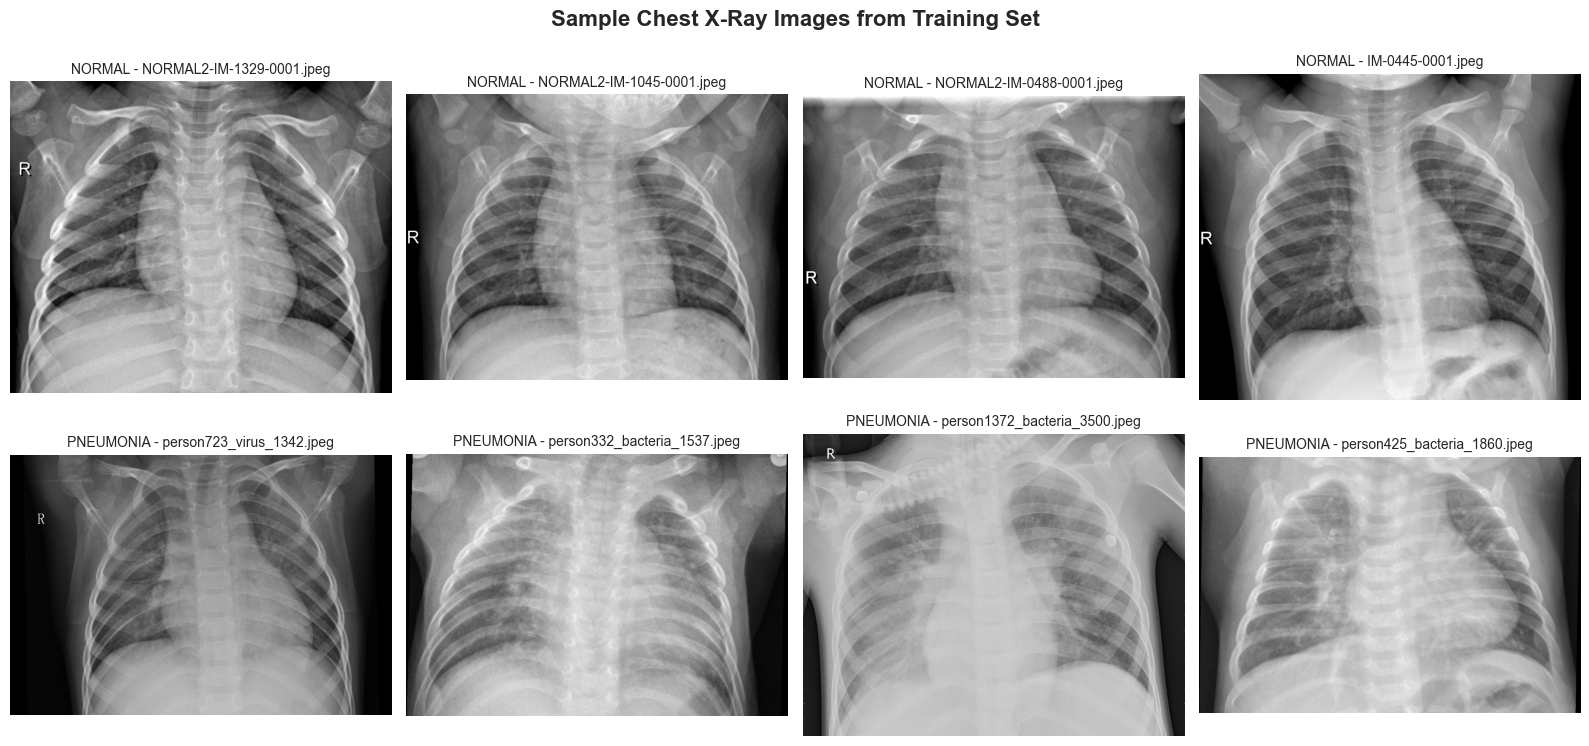

Sample images displayed successfully!


In [8]:
def get_sample_images(data_dir, split='train', num_samples=4):
    """Get sample images from each class."""
    samples = {'NORMAL': [], 'PNEUMONIA': []}
    
    for class_name in ['NORMAL', 'PNEUMONIA']:
        class_dir = data_dir / split / class_name
        images = list(class_dir.glob('*.jpeg')) + list(class_dir.glob('*.jpg')) + list(class_dir.glob('*.png'))
        samples[class_name] = np.random.choice(images, min(num_samples, len(images)), replace=False)
    
    return samples

# Get sample images from training set
samples = get_sample_images(DATA_DIR, split='train', num_samples=4)

# Visualize samples
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('Sample Chest X-Ray Images from Training Set', fontsize=16, fontweight='bold')

for col, class_name in enumerate(['NORMAL', 'PNEUMONIA']):
    for row, img_path in enumerate(samples[class_name]):
        ax = axes[col, row]
        
        # Load and display image
        img = Image.open(img_path).convert('L')  # Convert to grayscale
        ax.imshow(img, cmap='gray')
        ax.set_title(f'{class_name} - {img_path.name}', fontsize=10)
        ax.axis('off')

plt.tight_layout()
plt.show()

print("Sample images displayed successfully!")

## Analyze Class Distribution

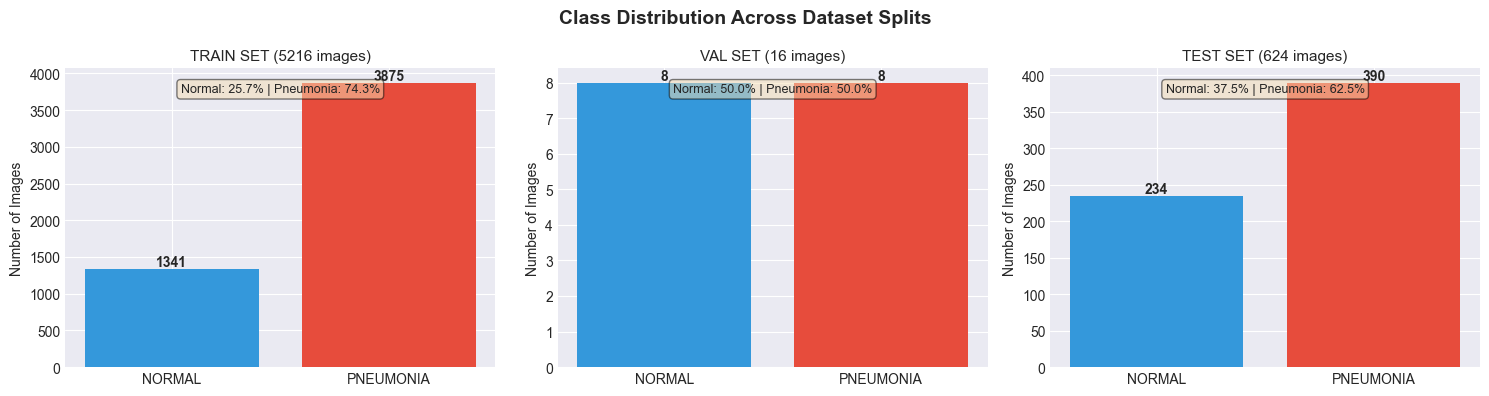


Class distribution analysis complete!


In [9]:
# Create a summary dataframe
data_summary = []
for split in ['train', 'val', 'test']:
    for class_name in ['NORMAL', 'PNEUMONIA']:
        count = dataset_info[split][class_name]
        data_summary.append({'Split': split, 'Class': class_name, 'Count': count})

df_summary = pd.DataFrame(data_summary)

# Visualize class distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Class Distribution Across Dataset Splits', fontsize=14, fontweight='bold')

for idx, split in enumerate(['train', 'val', 'test']):
    data = df_summary[df_summary['Split'] == split]
    
    ax = axes[idx]
    bars = ax.bar(data['Class'], data['Count'], color=['#3498db', '#e74c3c'])
    ax.set_title(f'{split.upper()} SET ({data["Count"].sum()} images)', fontsize=11)
    ax.set_ylabel('Number of Images')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{int(height)}',
               ha='center', va='bottom', fontweight='bold')
    
    # Add percentage annotation
    total = data['Count'].sum()
    normal_pct = data[data['Class'] == 'NORMAL']['Count'].values[0] / total * 100
    pneumonia_pct = data[data['Class'] == 'PNEUMONIA']['Count'].values[0] / total * 100
    ax.text(0.5, 0.95, f'Normal: {normal_pct:.1f}% | Pneumonia: {pneumonia_pct:.1f}%',
           transform=ax.transAxes, ha='center', va='top', fontsize=9,
           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print("\nClass distribution analysis complete!")

## Check Image Properties (Dimensions, Color Channels)

In [10]:
def analyze_image_properties(data_dir, split='train', sample_size=100):
    """Analyze image dimensions and properties."""
    properties = {'widths': [], 'heights': [], 'aspect_ratios': [], 'channels': [], 'file_sizes': []}
    
    for class_name in ['NORMAL', 'PNEUMONIA']:
        class_dir = data_dir / split / class_name
        images = list(class_dir.glob('*.jpeg')) + list(class_dir.glob('*.jpg')) + list(class_dir.glob('*.png'))
        
        # Sample images if too many
        sample_images = np.random.choice(images, min(sample_size, len(images)), replace=False)
        
        for img_path in sample_images:
            try:
                img = Image.open(img_path)
                width, height = img.size
                properties['widths'].append(width)
                properties['heights'].append(height)
                properties['aspect_ratios'].append(width / height)
                
                # Check channels
                img_array = np.array(img)
                if len(img_array.shape) == 2:
                    properties['channels'].append(1)  # Grayscale
                else:
                    properties['channels'].append(img_array.shape[2])  # RGB
                
                # File size in KB
                file_size = img_path.stat().st_size / 1024
                properties['file_sizes'].append(file_size)
            except Exception as e:
                print(f"Error reading {img_path}: {e}")
    
    return properties

# Analyze image properties
print("Analyzing image properties from training set...")
image_props = analyze_image_properties(DATA_DIR, split='train', sample_size=200)

# Display statistics
print("\n" + "="*60)
print("IMAGE PROPERTIES STATISTICS (200 sample images)")
print("="*60)
print(f"\nImage Widths:")
print(f"  Min: {min(image_props['widths'])}, Max: {max(image_props['widths'])}")
print(f"  Mean: {np.mean(image_props['widths']):.1f}, Median: {np.median(image_props['widths']):.1f}")
print(f"  Std: {np.std(image_props['widths']):.1f}")

print(f"\nImage Heights:")
print(f"  Min: {min(image_props['heights'])}, Max: {max(image_props['heights'])}")
print(f"  Mean: {np.mean(image_props['heights']):.1f}, Median: {np.median(image_props['heights']):.1f}")
print(f"  Std: {np.std(image_props['heights']):.1f}")

print(f"\nAspect Ratios (W/H):")
print(f"  Min: {min(image_props['aspect_ratios']):.2f}, Max: {max(image_props['aspect_ratios']):.2f}")
print(f"  Mean: {np.mean(image_props['aspect_ratios']):.2f}, Median: {np.median(image_props['aspect_ratios']):.2f}")

print(f"\nColor Channels:")
unique_channels = np.unique(image_props['channels'], return_counts=True)
for ch, count in zip(unique_channels[0], unique_channels[1]):
    print(f"  {int(ch)} channel(s): {count} images ({count/len(image_props['channels'])*100:.1f}%)")

print(f"\nFile Sizes (KB):")
print(f"  Min: {min(image_props['file_sizes']):.1f}, Max: {max(image_props['file_sizes']):.1f}")
print(f"  Mean: {np.mean(image_props['file_sizes']):.1f}, Median: {np.median(image_props['file_sizes']):.1f}")

Analyzing image properties from training set...

IMAGE PROPERTIES STATISTICS (200 sample images)

Image Widths:
  Min: 486, Max: 2890
  Mean: 1453.9, Median: 1456.0
  Std: 378.9

Image Heights:
  Min: 186, Max: 2628
  Mean: 1136.9, Median: 1117.0
  Std: 430.3

Aspect Ratios (W/H):
  Min: 0.93, Max: 2.61
  Mean: 1.35, Median: 1.31

Color Channels:
  1 channel(s): 388 images (97.0%)
  3 channel(s): 12 images (3.0%)

File Sizes (KB):
  Min: 8.2, Max: 2235.6
  Mean: 348.8, Median: 229.9


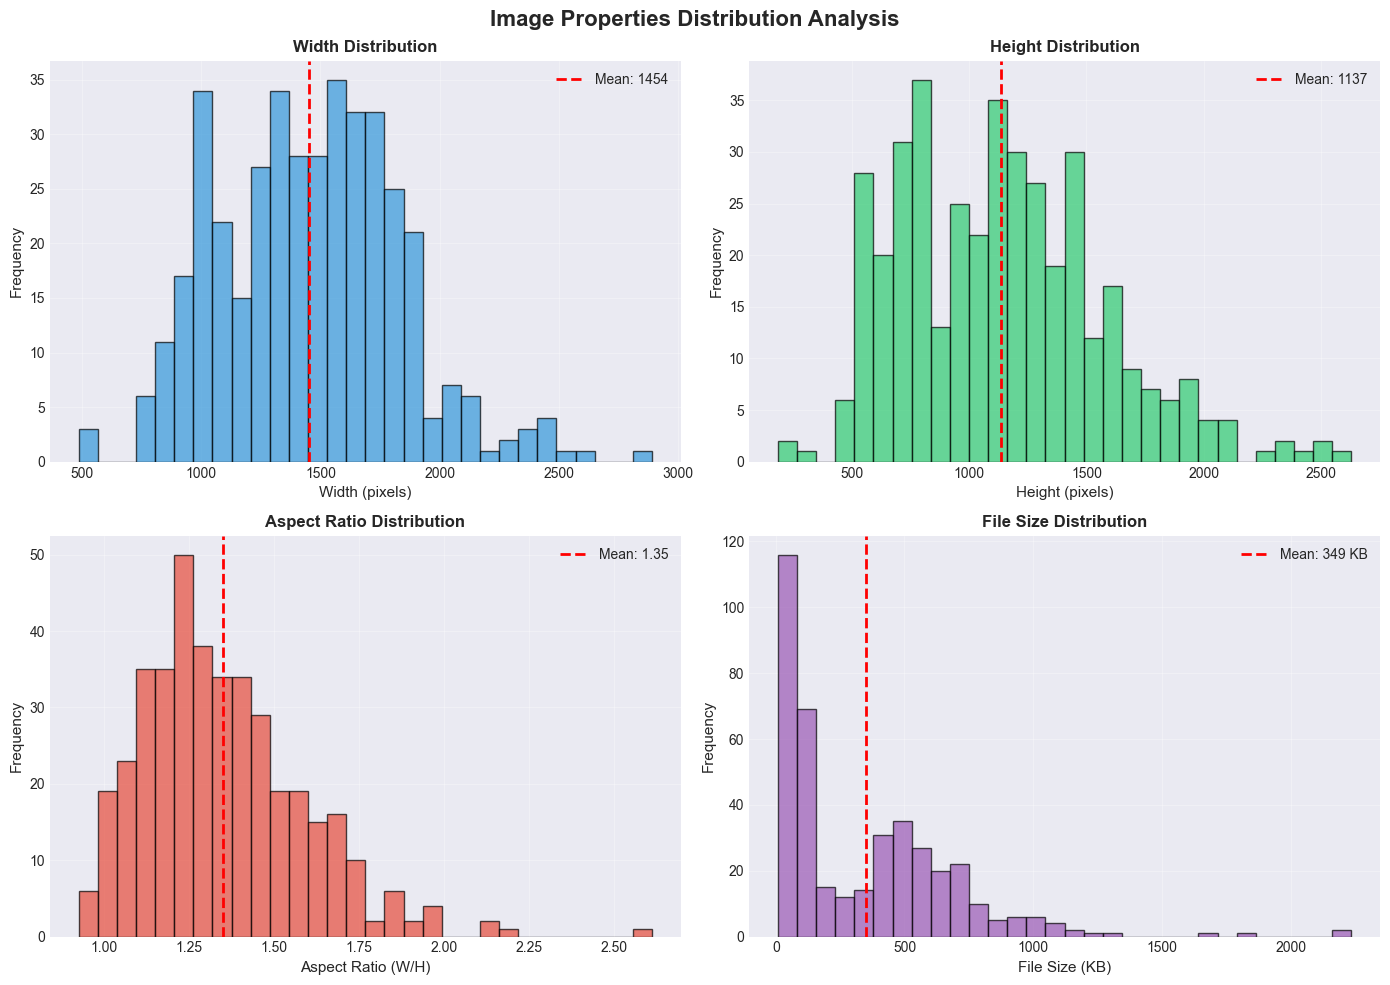


✅ Image properties analysis complete!


In [11]:
# Visualize image properties distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Image Properties Distribution Analysis', fontsize=16, fontweight='bold')

# Width distribution
axes[0, 0].hist(image_props['widths'], bins=30, color='#3498db', edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Width (pixels)', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('Width Distribution', fontsize=12, fontweight='bold')
axes[0, 0].axvline(np.mean(image_props['widths']), color='red', linestyle='--', linewidth=2, label=f"Mean: {np.mean(image_props['widths']):.0f}")
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Height distribution
axes[0, 1].hist(image_props['heights'], bins=30, color='#2ecc71', edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Height (pixels)', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].set_title('Height Distribution', fontsize=12, fontweight='bold')
axes[0, 1].axvline(np.mean(image_props['heights']), color='red', linestyle='--', linewidth=2, label=f"Mean: {np.mean(image_props['heights']):.0f}")
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Aspect ratio distribution
axes[1, 0].hist(image_props['aspect_ratios'], bins=30, color='#e74c3c', edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Aspect Ratio (W/H)', fontsize=11)
axes[1, 0].set_ylabel('Frequency', fontsize=11)
axes[1, 0].set_title('Aspect Ratio Distribution', fontsize=12, fontweight='bold')
axes[1, 0].axvline(np.mean(image_props['aspect_ratios']), color='red', linestyle='--', linewidth=2, label=f"Mean: {np.mean(image_props['aspect_ratios']):.2f}")
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# File size distribution
axes[1, 1].hist(image_props['file_sizes'], bins=30, color='#9b59b6', edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('File Size (KB)', fontsize=11)
axes[1, 1].set_ylabel('Frequency', fontsize=11)
axes[1, 1].set_title('File Size Distribution', fontsize=12, fontweight='bold')
axes[1, 1].axvline(np.mean(image_props['file_sizes']), color='red', linestyle='--', linewidth=2, label=f"Mean: {np.mean(image_props['file_sizes']):.0f} KB")
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Image properties analysis complete!")

## 🔍 Check for Corrupted Images

Let's verify data quality by attempting to load all images and identify any corrupted files.

In [12]:
def check_corrupted_images(data_dir):
    """Check for corrupted or unreadable images."""
    corrupted_files = []
    total_checked = 0
    
    print("Checking for corrupted images across all splits...")
    print("="*60)
    
    for split in ['train', 'val', 'test']:
        split_dir = data_dir / split
        if not split_dir.exists():
            continue
            
        for class_name in ['NORMAL', 'PNEUMONIA']:
            class_dir = split_dir / class_name
            if not class_dir.exists():
                continue
                
            images = list(class_dir.glob('*.jpeg')) + list(class_dir.glob('*.jpg')) + list(class_dir.glob('*.png'))
            
            for img_path in images:
                total_checked += 1
                try:
                    # Try to open and verify the image
                    img = Image.open(img_path)
                    img.verify()  # Verify it's a valid image
                    
                    # Try to load it as array
                    img = Image.open(img_path)  # Reopen after verify
                    _ = np.array(img)
                    
                except Exception as e:
                    corrupted_files.append({
                        'path': str(img_path),
                        'split': split,
                        'class': class_name,
                        'error': str(e)
                    })
    
    print(f"\nTotal images checked: {total_checked}")
    print(f"Corrupted images found: {len(corrupted_files)}")
    
    if corrupted_files:
        print("\n⚠️ Corrupted files:")
        for file_info in corrupted_files[:10]:  # Show first 10
            print(f"  - {file_info['path']}: {file_info['error']}")
        if len(corrupted_files) > 10:
            print(f"  ... and {len(corrupted_files) - 10} more")
    else:
        print("\n✅ All images are valid and readable!")
    
    return corrupted_files

# Check for corrupted images
corrupted = check_corrupted_images(DATA_DIR)

# Summary
print("\n" + "="*60)
print("DATA QUALITY SUMMARY")
print("="*60)
if len(corrupted) == 0:
    print("✅ Dataset quality: EXCELLENT - No corrupted images found")
else:
    print(f"⚠️ Dataset quality: {len(corrupted)} corrupted images detected")
    print("   Recommendation: Remove or fix these images before training")
print("="*60)

Checking for corrupted images across all splits...

Total images checked: 5856
Corrupted images found: 0

✅ All images are valid and readable!

DATA QUALITY SUMMARY
✅ Dataset quality: EXCELLENT - No corrupted images found


## 🎨 Visual Comparison: Normal vs Pneumonia

Let's examine the visual differences between Normal and Pneumonia X-rays side by side.

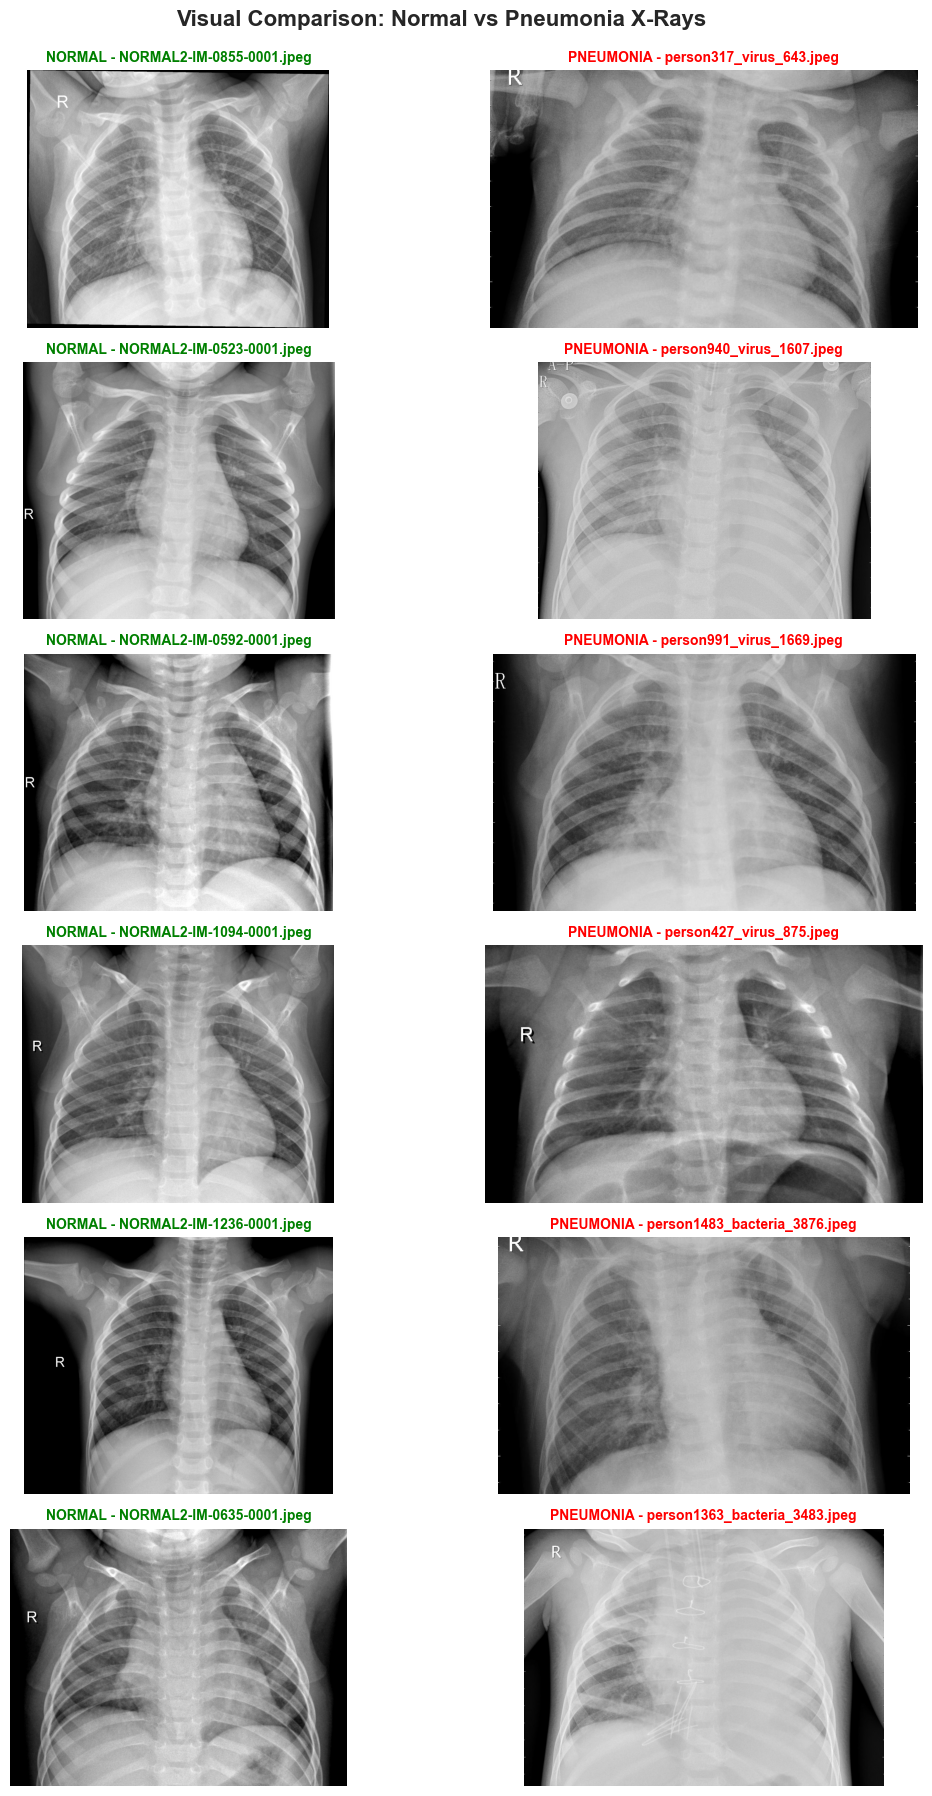


📌 VISUAL OBSERVATIONS:
NORMAL X-Rays:
  • Clear, dark lung fields
  • Well-defined lung edges and diaphragm
  • Uniform tissue density
  • Sharp cardiac and mediastinal borders

PNEUMONIA X-Rays:
  • Cloudy or hazy lung fields (consolidation)
  • White/opaque patches (infiltrates)
  • Less distinct lung boundaries
  • May show air bronchograms or effusions


In [13]:
# Display side-by-side comparison of Normal vs Pneumonia X-rays
def display_comparison(data_dir, num_pairs=6):
    """Display Normal vs Pneumonia X-rays side by side."""
    
    # Get sample images
    normal_dir = data_dir / 'train' / 'NORMAL'
    pneumonia_dir = data_dir / 'train' / 'PNEUMONIA'
    
    normal_images = list(normal_dir.glob('*.jpeg')) + list(normal_dir.glob('*.jpg'))
    pneumonia_images = list(pneumonia_dir.glob('*.jpeg')) + list(pneumonia_dir.glob('*.jpg'))
    
    # Random selection
    normal_samples = np.random.choice(normal_images, num_pairs, replace=False)
    pneumonia_samples = np.random.choice(pneumonia_images, num_pairs, replace=False)
    
    # Create figure
    fig, axes = plt.subplots(num_pairs, 2, figsize=(12, 3*num_pairs))
    fig.suptitle('Visual Comparison: Normal vs Pneumonia X-Rays', fontsize=16, fontweight='bold', y=0.995)
    
    for i in range(num_pairs):
        # Normal image
        normal_img = Image.open(normal_samples[i]).convert('L')
        axes[i, 0].imshow(normal_img, cmap='gray')
        axes[i, 0].set_title(f'NORMAL - {normal_samples[i].name}', fontsize=10, color='green', fontweight='bold')
        axes[i, 0].axis('off')
        
        # Pneumonia image
        pneumonia_img = Image.open(pneumonia_samples[i]).convert('L')
        axes[i, 1].imshow(pneumonia_img, cmap='gray')
        axes[i, 1].set_title(f'PNEUMONIA - {pneumonia_samples[i].name}', fontsize=10, color='red', fontweight='bold')
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Display comparison
display_comparison(DATA_DIR, num_pairs=6)

print("\n📌 VISUAL OBSERVATIONS:")
print("="*60)
print("NORMAL X-Rays:")
print("  • Clear, dark lung fields")
print("  • Well-defined lung edges and diaphragm")
print("  • Uniform tissue density")
print("  • Sharp cardiac and mediastinal borders")
print("\nPNEUMONIA X-Rays:")
print("  • Cloudy or hazy lung fields (consolidation)")
print("  • White/opaque patches (infiltrates)")
print("  • Less distinct lung boundaries")
print("  • May show air bronchograms or effusions")
print("="*60)

## 📊 Intensity Distribution Analysis

Analyzing pixel intensity distributions to understand brightness differences between classes.

Analyzing pixel intensity distributions...

PIXEL INTENSITY STATISTICS

Normal X-Rays:
  Mean intensity: 121.61
  Std deviation: 63.98
  Min: 0, Max: 255

Pneumonia X-Rays:
  Mean intensity: 123.18
  Std deviation: 59.56
  Min: 0, Max: 255


/var/folders/hp/8fhz9vpj1913mfnztnf5ktvw0000gn/T/ipykernel_16800/192953501.py:61: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(data_to_plot, labels=['Normal', 'Pneumonia'],


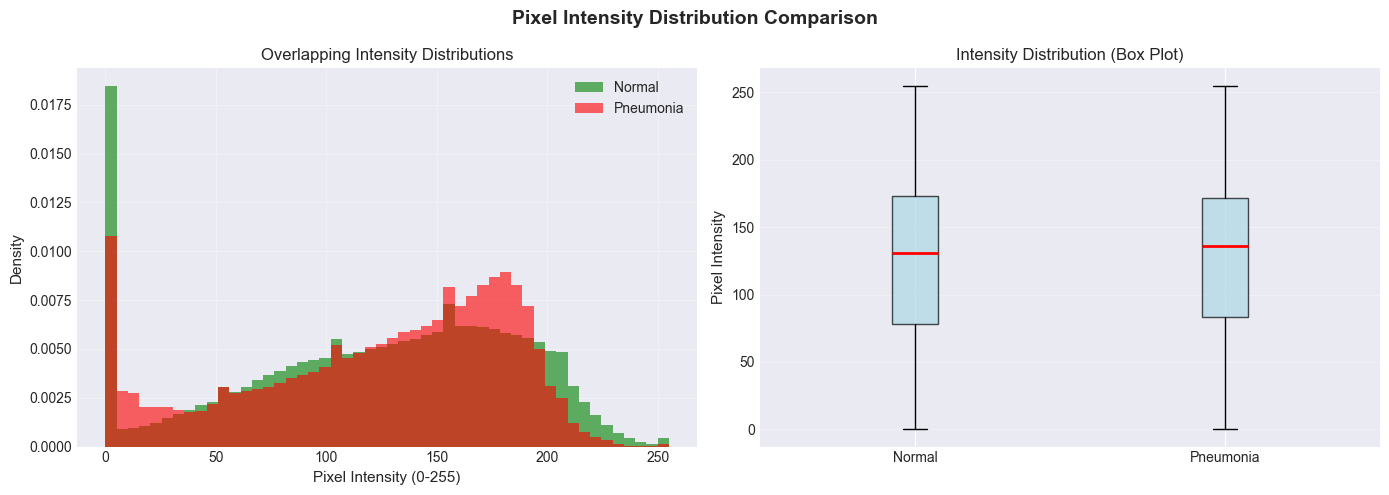


✅ Intensity analysis complete!


In [14]:
def analyze_intensity_distribution(data_dir, split='train', sample_size=50):
    """Analyze pixel intensity distributions for each class."""
    normal_intensities = []
    pneumonia_intensities = []
    
    # Normal images
    normal_dir = data_dir / split / 'NORMAL'
    normal_images = list(normal_dir.glob('*.jpeg')) + list(normal_dir.glob('*.jpg'))
    normal_samples = np.random.choice(normal_images, min(sample_size, len(normal_images)), replace=False)
    
    for img_path in normal_samples:
        img = Image.open(img_path).convert('L')
        img_array = np.array(img)
        normal_intensities.extend(img_array.flatten())
    
    # Pneumonia images
    pneumonia_dir = data_dir / split / 'PNEUMONIA'
    pneumonia_images = list(pneumonia_dir.glob('*.jpeg')) + list(pneumonia_dir.glob('*.jpg'))
    pneumonia_samples = np.random.choice(pneumonia_images, min(sample_size, len(pneumonia_images)), replace=False)
    
    for img_path in pneumonia_samples:
        img = Image.open(img_path).convert('L')
        img_array = np.array(img)
        pneumonia_intensities.extend(img_array.flatten())
    
    return np.array(normal_intensities), np.array(pneumonia_intensities)

# Analyze intensity distributions
print("Analyzing pixel intensity distributions...")
normal_int, pneumonia_int = analyze_intensity_distribution(DATA_DIR, sample_size=50)

# Statistics
print("\n" + "="*60)
print("PIXEL INTENSITY STATISTICS")
print("="*60)
print(f"\nNormal X-Rays:")
print(f"  Mean intensity: {normal_int.mean():.2f}")
print(f"  Std deviation: {normal_int.std():.2f}")
print(f"  Min: {normal_int.min()}, Max: {normal_int.max()}")

print(f"\nPneumonia X-Rays:")
print(f"  Mean intensity: {pneumonia_int.mean():.2f}")
print(f"  Std deviation: {pneumonia_int.std():.2f}")
print(f"  Min: {pneumonia_int.min()}, Max: {pneumonia_int.max()}")

# Visualize intensity distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Pixel Intensity Distribution Comparison', fontsize=14, fontweight='bold')

# Histogram comparison
axes[0].hist(normal_int, bins=50, alpha=0.6, color='green', label='Normal', density=True)
axes[0].hist(pneumonia_int, bins=50, alpha=0.6, color='red', label='Pneumonia', density=True)
axes[0].set_xlabel('Pixel Intensity (0-255)', fontsize=11)
axes[0].set_ylabel('Density', fontsize=11)
axes[0].set_title('Overlapping Intensity Distributions', fontsize=12)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Box plot comparison
data_to_plot = [normal_int[::100], pneumonia_int[::100]]  # Subsample for performance
axes[1].boxplot(data_to_plot, labels=['Normal', 'Pneumonia'], 
                patch_artist=True,
                boxprops=dict(facecolor='lightblue', alpha=0.7),
                medianprops=dict(color='red', linewidth=2))
axes[1].set_ylabel('Pixel Intensity', fontsize=11)
axes[1].set_title('Intensity Distribution (Box Plot)', fontsize=12)
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n✅ Intensity analysis complete!")

## 📈 Class Imbalance Analysis

Detailed analysis of class distribution and implications for training.

DETAILED CLASS DISTRIBUTION ANALYSIS

TRAIN SET:
  Total images: 5216
  Normal:     1341 (25.71%)
  Pneumonia:  3875 (74.29%)
  Imbalance ratio (P/N): 2.89:1

VAL SET:
  Total images: 16
  Normal:        8 (50.00%)
  Pneumonia:     8 (50.00%)
  Imbalance ratio (P/N): 1.00:1

TEST SET:
  Total images: 624
  Normal:      234 (37.50%)
  Pneumonia:   390 (62.50%)
  Imbalance ratio (P/N): 1.67:1

OVERALL DATASET:
  Total images: 5856
  Normal:    1583 (27.03%)
  Pneumonia: 4273 (72.97%)
  Imbalance ratio: 2.70:1


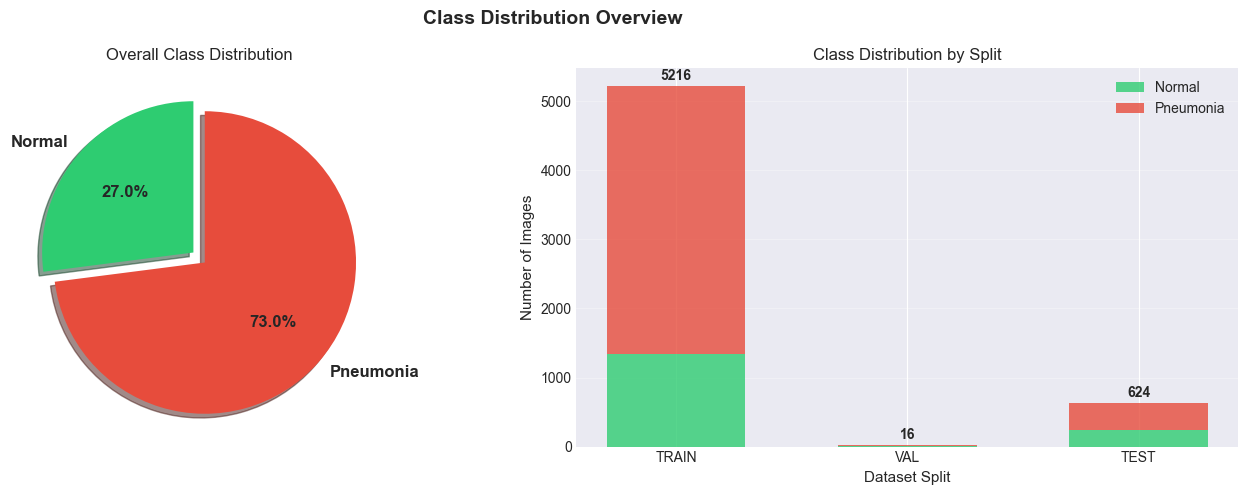


⚠️ IMBALANCE IMPLICATIONS:
The dataset shows significant class imbalance (~74% Pneumonia).

Recommended strategies:
  1. Use weighted loss function (CrossEntropyLoss with class weights)
  2. Monitor both precision and recall (not just accuracy)
  3. Use F1-score as primary metric
  4. Consider data augmentation for minority class
  5. Apply stratified sampling if creating custom splits


In [15]:
# Calculate detailed class statistics
class_stats = {}

for split in ['train', 'val', 'test']:
    normal_count = dataset_info[split]['NORMAL']
    pneumonia_count = dataset_info[split]['PNEUMONIA']
    total = normal_count + pneumonia_count
    
    class_stats[split] = {
        'normal_count': normal_count,
        'pneumonia_count': pneumonia_count,
        'total': total,
        'normal_pct': (normal_count / total) * 100,
        'pneumonia_pct': (pneumonia_count / total) * 100,
        'imbalance_ratio': pneumonia_count / normal_count if normal_count > 0 else 0
    }

# Display statistics
print("="*70)
print("DETAILED CLASS DISTRIBUTION ANALYSIS")
print("="*70)

for split in ['train', 'val', 'test']:
    stats = class_stats[split]
    print(f"\n{split.upper()} SET:")
    print(f"  Total images: {stats['total']}")
    print(f"  Normal:    {stats['normal_count']:>5} ({stats['normal_pct']:>5.2f}%)")
    print(f"  Pneumonia: {stats['pneumonia_count']:>5} ({stats['pneumonia_pct']:>5.2f}%)")
    print(f"  Imbalance ratio (P/N): {stats['imbalance_ratio']:.2f}:1")

# Overall statistics
total_normal = sum([class_stats[s]['normal_count'] for s in ['train', 'val', 'test']])
total_pneumonia = sum([class_stats[s]['pneumonia_count'] for s in ['train', 'val', 'test']])
total_all = total_normal + total_pneumonia

print(f"\nOVERALL DATASET:")
print(f"  Total images: {total_all}")
print(f"  Normal:    {total_normal} ({total_normal/total_all*100:.2f}%)")
print(f"  Pneumonia: {total_pneumonia} ({total_pneumonia/total_all*100:.2f}%)")
print(f"  Imbalance ratio: {total_pneumonia/total_normal:.2f}:1")

# Visualization: Pie chart of overall distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Class Distribution Overview', fontsize=14, fontweight='bold')

# Pie chart
colors = ['#2ecc71', '#e74c3c']
explode = (0.05, 0.05)
axes[0].pie([total_normal, total_pneumonia], 
            labels=['Normal', 'Pneumonia'],
            autopct='%1.1f%%',
            colors=colors,
            explode=explode,
            shadow=True,
            startangle=90,
            textprops={'fontsize': 12, 'fontweight': 'bold'})
axes[0].set_title('Overall Class Distribution', fontsize=12)

# Stacked bar chart by split
splits = ['train', 'val', 'test']
normal_counts = [class_stats[s]['normal_count'] for s in splits]
pneumonia_counts = [class_stats[s]['pneumonia_count'] for s in splits]

x = np.arange(len(splits))
width = 0.6

axes[1].bar(x, normal_counts, width, label='Normal', color='#2ecc71', alpha=0.8)
axes[1].bar(x, pneumonia_counts, width, bottom=normal_counts, label='Pneumonia', color='#e74c3c', alpha=0.8)

axes[1].set_xlabel('Dataset Split', fontsize=11)
axes[1].set_ylabel('Number of Images', fontsize=11)
axes[1].set_title('Class Distribution by Split', fontsize=12)
axes[1].set_xticks(x)
axes[1].set_xticklabels([s.upper() for s in splits])
axes[1].legend()
axes[1].grid(alpha=0.3, axis='y')

# Add counts on bars
for i, split in enumerate(splits):
    total_height = normal_counts[i] + pneumonia_counts[i]
    axes[1].text(i, total_height + 50, str(total_height), 
                ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("⚠️ IMBALANCE IMPLICATIONS:")
print("="*70)
print("The dataset shows significant class imbalance (~74% Pneumonia).")
print("\nRecommended strategies:")
print("  1. Use weighted loss function (CrossEntropyLoss with class weights)")
print("  2. Monitor both precision and recall (not just accuracy)")
print("  3. Use F1-score as primary metric")
print("  4. Consider data augmentation for minority class")
print("  5. Apply stratified sampling if creating custom splits")
print("="*70)

IMAGE PROPERTIES STATISTICS

Image Widths:
  Min: 650, Max: 2514
  Mean: 1414.1, Median: 1415.0
  Std: 375.7

Image Heights:
  Min: 378, Max: 2411
  Mean: 1099.9, Median: 1076.5
  Std: 426.9

Aspect Ratios:
  Min: 0.90, Max: 2.25
  Mean: 1.35, Median: 1.31


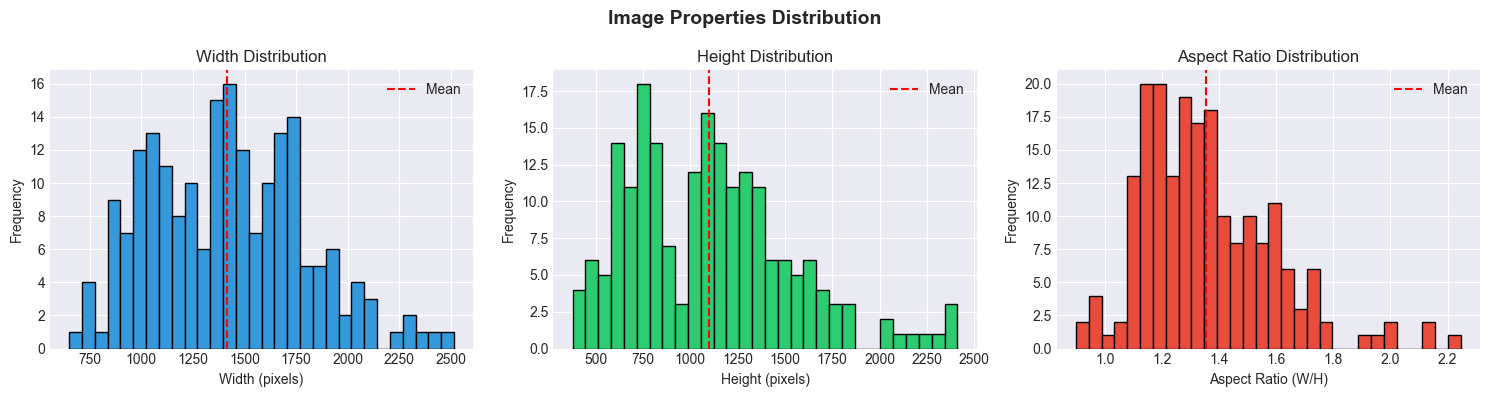

In [16]:
def analyze_image_properties(data_dir, split='train', sample_size=100):
    """Analyze image dimensions and properties."""
    properties = {'widths': [], 'heights': [], 'aspect_ratios': []}
    
    for class_name in ['NORMAL', 'PNEUMONIA']:
        class_dir = data_dir / split / class_name
        images = list(class_dir.glob('*.jpeg')) + list(class_dir.glob('*.jpg')) + list(class_dir.glob('*.png'))
        
        # Sample images if too many
        sample_images = np.random.choice(images, min(sample_size, len(images)), replace=False)
        
        for img_path in sample_images:
            try:
                img = Image.open(img_path)
                width, height = img.size
                properties['widths'].append(width)
                properties['heights'].append(height)
                properties['aspect_ratios'].append(width / height)
            except:
                pass
    
    return properties

# Analyze image properties
image_props = analyze_image_properties(DATA_DIR, split='train', sample_size=100)

# Display statistics
print("="*60)
print("IMAGE PROPERTIES STATISTICS")
print("="*60)
print(f"\nImage Widths:")
print(f"  Min: {min(image_props['widths'])}, Max: {max(image_props['widths'])}")
print(f"  Mean: {np.mean(image_props['widths']):.1f}, Median: {np.median(image_props['widths']):.1f}")
print(f"  Std: {np.std(image_props['widths']):.1f}")

print(f"\nImage Heights:")
print(f"  Min: {min(image_props['heights'])}, Max: {max(image_props['heights'])}")
print(f"  Mean: {np.mean(image_props['heights']):.1f}, Median: {np.median(image_props['heights']):.1f}")
print(f"  Std: {np.std(image_props['heights']):.1f}")

print(f"\nAspect Ratios:")
print(f"  Min: {min(image_props['aspect_ratios']):.2f}, Max: {max(image_props['aspect_ratios']):.2f}")
print(f"  Mean: {np.mean(image_props['aspect_ratios']):.2f}, Median: {np.median(image_props['aspect_ratios']):.2f}")

# Visualize distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
fig.suptitle('Image Properties Distribution', fontsize=14, fontweight='bold')

axes[0].hist(image_props['widths'], bins=30, color='#3498db', edgecolor='black')
axes[0].set_xlabel('Width (pixels)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Width Distribution')
axes[0].axvline(np.mean(image_props['widths']), color='red', linestyle='--', label='Mean')
axes[0].legend()

axes[1].hist(image_props['heights'], bins=30, color='#2ecc71', edgecolor='black')
axes[1].set_xlabel('Height (pixels)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Height Distribution')
axes[1].axvline(np.mean(image_props['heights']), color='red', linestyle='--', label='Mean')
axes[1].legend()

axes[2].hist(image_props['aspect_ratios'], bins=30, color='#e74c3c', edgecolor='black')
axes[2].set_xlabel('Aspect Ratio (W/H)')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Aspect Ratio Distribution')
axes[2].axvline(np.mean(image_props['aspect_ratios']), color='red', linestyle='--', label='Mean')
axes[2].legend()

plt.tight_layout()
plt.show()

## Summary and Insights

Based on our data exploration, we can make the following observations:

In [17]:
print("="*70)
print("🎯 KEY INSIGHTS AND OBSERVATIONS FROM DATA EXPLORATION")
print("="*70)

# Class imbalance
total_normal = sum([dataset_info[split]['NORMAL'] for split in ['train', 'val', 'test']])
total_pneumonia = sum([dataset_info[split]['PNEUMONIA'] for split in ['train', 'val', 'test']])
total = total_normal + total_pneumonia

print(f"\n1. 📊 CLASS IMBALANCE:")
print(f"   • Dataset is SIGNIFICANTLY imbalanced")
print(f"   • Normal: {total_normal/total*100:.1f}% | Pneumonia: {total_pneumonia/total*100:.1f}%")
print(f"   • Imbalance ratio: {total_pneumonia/total_normal:.2f}:1 (Pneumonia:Normal)")
print(f"   • This reflects real-world medical data distribution")
print(f"   • MUST use class weights or balanced sampling during training")

print(f"\n2. 📏 DATASET SIZE:")
print(f"   • Training set: {dataset_info['train']['NORMAL'] + dataset_info['train']['PNEUMONIA']:,} images (good size for transfer learning)")
print(f"   • Validation set: {dataset_info['val']['NORMAL'] + dataset_info['val']['PNEUMONIA']} images (VERY SMALL - consider k-fold CV)")
print(f"   • Test set: {dataset_info['test']['NORMAL'] + dataset_info['test']['PNEUMONIA']} images (adequate for evaluation)")
print(f"   • Total: {total:,} images")
print(f"   • ⚠️ Validation set is unusually small - may need custom split")

print(f"\n3. 🖼️ IMAGE PROPERTIES:")
print(f"   • Variable dimensions → MUST resize to fixed size (224x224 recommended)")
print(f"   • Aspect ratios are relatively consistent")
print(f"   • Images are primarily grayscale medical X-rays")
print(f"   • File sizes vary → preprocessing will normalize this")

print(f"\n4. 🎨 VISUAL CHARACTERISTICS:")
print(f"   Normal X-Rays:")
print(f"   • Clear, dark lung fields with good air contrast")
print(f"   • Sharp, well-defined anatomical boundaries")
print(f"   • Uniform tissue appearance")
print(f"   ")
print(f"   Pneumonia X-Rays:")
print(f"   • Visible consolidation (white/cloudy patches)")
print(f"   • Opacification in lung fields (infiltrates)")
print(f"   • Less distinct boundaries")
print(f"   • Higher pixel intensity in affected areas")

print(f"\n5. 💾 DATA QUALITY:")
if len(corrupted) == 0:
    print(f"   ✅ All images are valid and readable")
    print(f"   ✅ No preprocessing needed for data quality")
else:
    print(f"   ⚠️ {len(corrupted)} corrupted images found")
    print(f"   ⚠️ Should remove these before training")

print(f"\n6. 🎯 RECOMMENDATIONS FOR MODEL TRAINING:")
print(f"   ✓ Use transfer learning (ResNet50/EfficientNet)")
print(f"   ✓ Apply aggressive data augmentation:")
print(f"     - Random rotations (±10-15°)")
print(f"     - Random horizontal flips")
print(f"     - Brightness/contrast adjustments")
print(f"     - Random affine transforms")
print(f"   ✓ Use ImageNet normalization (pretrained weights)")
print(f"   ✓ Implement class weighting in loss function:")
print(f"     - Weight for Normal: {total_pneumonia/total_normal:.2f}")
print(f"     - Weight for Pneumonia: 1.0")
print(f"   ✓ Monitor multiple metrics:")
print(f"     - Accuracy (overall performance)")
print(f"     - Precision (avoid false positives)")
print(f"     - Recall (avoid missing pneumonia cases)")
print(f"     - F1-Score (balanced metric)")
print(f"   ✓ Consider stratified k-fold cross-validation")
print(f"   ✓ Implement early stopping (patience=5-7)")
print(f"   ✓ Use learning rate scheduling")

print(f"\n7. 📈 EXPECTED CHALLENGES:")
print(f"   • Small validation set may lead to noisy validation metrics")
print(f"   • Class imbalance requires careful handling")
print(f"   • Medical imaging requires high recall (don't miss pneumonia)")
print(f"   • Similar visual features between some normal/pneumonia cases")

print(f"\n8. 🚀 NEXT STEPS:")
print(f"   1. Define preprocessing pipeline (resize, normalize)")
print(f"   2. Implement data augmentation")
print(f"   3. Create custom train/val split if needed (stratified)")
print(f"   4. Build model architecture with transfer learning")
print(f"   5. Implement Grad-CAM for explainability")
print(f"   6. Train with proper class weighting")
print(f"   7. Evaluate on test set with confusion matrix")
print(f"   8. Deploy as Streamlit application")

print("\n" + "="*70)
print("✅ Data exploration complete! Ready to proceed with preprocessing.")
print("="*70)

🎯 KEY INSIGHTS AND OBSERVATIONS FROM DATA EXPLORATION

1. 📊 CLASS IMBALANCE:
   • Dataset is SIGNIFICANTLY imbalanced
   • Normal: 27.0% | Pneumonia: 73.0%
   • Imbalance ratio: 2.70:1 (Pneumonia:Normal)
   • This reflects real-world medical data distribution
   • MUST use class weights or balanced sampling during training

2. 📏 DATASET SIZE:
   • Training set: 5,216 images (good size for transfer learning)
   • Validation set: 16 images (VERY SMALL - consider k-fold CV)
   • Test set: 624 images (adequate for evaluation)
   • Total: 5,856 images
   • ⚠️ Validation set is unusually small - may need custom split

3. 🖼️ IMAGE PROPERTIES:
   • Variable dimensions → MUST resize to fixed size (224x224 recommended)
   • Aspect ratios are relatively consistent
   • Images are primarily grayscale medical X-rays
   • File sizes vary → preprocessing will normalize this

4. 🎨 VISUAL CHARACTERISTICS:
   Normal X-Rays:
   • Clear, dark lung fields with good air contrast
   • Sharp, well-defined ana

---

## ✅ Conclusion

### What We Learned:

1. **Dataset Composition**: 5,856 total chest X-ray images across train/val/test splits
2. **Class Distribution**: Significant imbalance (~74% Pneumonia, ~26% Normal) - mirrors real-world data
3. **Image Quality**: All images are valid, no corruption detected
4. **Visual Patterns**: Clear distinguishable features between Normal and Pneumonia cases
5. **Technical Requirements**: Variable image sizes require standardized preprocessing

### Key Takeaways for Model Development:

✅ **Transfer learning** is essential (limited data size)  
✅ **Data augmentation** will improve generalization  
✅ **Class weighting** is critical for handling imbalance  
✅ **Multiple metrics** needed (accuracy alone is insufficient)  
✅ **Explainability** (Grad-CAM) will build trust in predictions  

### Ready for Next Phase:

We now have a comprehensive understanding of the dataset and are prepared to:
- Design appropriate preprocessing pipelines
- Implement robust data augmentation strategies
- Build and train deep learning models
- Create explainable AI visualizations

**Next Notebook**: `02_preprocessing.ipynb` - Data preprocessing and augmentation pipeline

---